In [1]:
import pandas as pd
import os
import sys
import re
import json
import concurrent.futures
from tqdm import tqdm
import random
import pickle
from sklearn.model_selection import train_test_split
import torch
import pickle 
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
model_test_run = False #This reduces the data generated by selecting significantly lesser number of sessions to test the model
sequence_augmentation = True

base_path = '../../../datasets/sequential/'
augmentation_folder = 'aug/' if sequence_augmentation else 'non_aug/'
if model_test_run:
    augmentation_folder = 'test/aug/' if sequence_augmentation else 'test/non_aug/'
sequence_path = f'{base_path}{augmentation_folder}seq'

def plot_label_hist(df):
    print('Total number of unique_labels',len(df['item_id_target'].unique().tolist()))
    print('unique_labels',sorted(df['item_id_target'].unique().tolist()))
    value_counts = df['item_id_target'].value_counts(normalize=True).sort_values() * 100
    plt.figure(figsize=(5, 3))
    value_counts.plot(kind='bar')
    plt.title('Percentage of item_num in data')
    plt.xlabel('item_num')
    plt.ylabel('Percentage')
    plt.show()

In [3]:
os.getcwd()

'/Volumes/Workspace/In-Car CARSI/carsii/pretrain/rareevent/preprocessing'

In [4]:
target_train = pd.read_csv(os.path.join(sequence_path, 'train.tsv'), sep='\t')
target_test = pd.read_csv(os.path.join(sequence_path, 'test.tsv'), sep='\t')

Total number of unique_labels 26
unique_labels [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28]


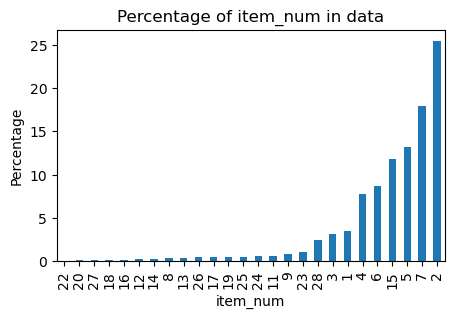

In [5]:
plot_label_hist(target_train)

Total number of unique_labels 23
unique_labels [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 28]


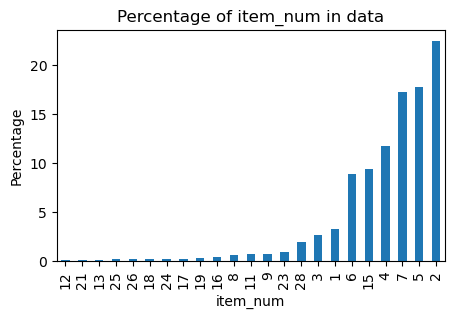

In [6]:
plot_label_hist(target_test)

In [7]:
value_counts = target_train['item_id_target'].value_counts()
cumulative_percentage = value_counts.cumsum() / len(target_train)
common_items = cumulative_percentage[cumulative_percentage <= 0.8].index.tolist()
target_train['common_item'] = target_train['item_id_target'].apply(lambda x: 1 if x in common_items else 0)
target_train

,window_id,item_id_seq_train,item_id_target,interaction_time_delta_train,session,common_item
0,0,2 1 2,2,10 21 19,16.0,1
1,1,2 1,2,10 21,16.0,1
2,2,2,1,10,16.0,0
3,3,4,5,0,33.0,1
4,4,4,5,0,35.0,1
...,...,...,...,...,...,...
4421,4421,2 4,5,23 0,5364.0,1
4422,4422,2,4,23,5364.0,0
4423,4423,5,6,0,5387.0,1
4424,4424,7,15,8,5388.0,1


In [8]:
target_test['common_item'] = target_test['item_id_target'].apply(lambda x: 1 if x in common_items else 0)
target_test

,window_id,item_id_seq_train,item_id_target,interaction_time_delta_train,session,common_item
0,0,3,2,0,25.0,1
1,1,8,7,3,94.0,1
2,2,3 2,2,0 7,172.0,1
3,3,3,2,0,172.0,1
4,4,2 5 2 1 3,2,3 127 16 20 0,173.0,1
...,...,...,...,...,...,...
1023,1023,5 15 7,5,9 4 22,5346.0,1
1024,1024,5 15,7,9 4,5346.0,1
1025,1025,5,15,9,5346.0,1
1026,1026,7 11,7,27 11,5399.0,1


In [9]:
directory_path = '../datasets/sequential/aug/seq'
os.makedirs(directory_path, exist_ok=True)
target_test.to_csv(os.path.join(directory_path, 'test.tsv'), sep='\t', index=False)
target_train.to_csv(os.path.join(directory_path, 'train.tsv'), sep='\t', index=False)

In [10]:
count = target_train.common_item.value_counts()
ratio = count[0] / count[1]
pos_ratio_tensor = torch.tensor(ratio, dtype=torch.float32)
parameter_path = '../datasets/sequential/aug/parameters'
os.makedirs(parameter_path, exist_ok=True)
with open(os.path.join(parameter_path, 'param.pkl'), 'wb') as f:
    pickle.dump(pos_ratio_tensor, f)
print(pos_ratio_tensor)

tensor(0.2960)
